In [1]:
!pip install wandb
!pip install import-ipynb

In [2]:
# Imports
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import wandb
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd '/content/gdrive/MyDrive/deepsf/code_JS'
import import_ipynb

# do_plots_model_results
from do_plots_model_results import val_loss_vs_epoch, ReturnPlotSolution, plot_pred_vs_real, corr_vs_biotype

# class_models_functions
from class_models_pytorch import evaluate, do_training, fit, DeepSF, DeepSF_2hidden 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1H6MhDWUnnQQrC4_3ci_6saOGAZ1koHG4/deepsf/code_JS
importing Jupyter notebook from do_plots_model_results.ipynb
importing Jupyter notebook from class_models_pytorch.ipynb


In [4]:
path = '/content/gdrive/MyDrive/deepsf/code_JS/folder_rawdata_processing/'

# Read the data from the file.
with open(path+'3-pipeline_files.pkl', 'rb') as fid:
     result = pickle.load(fid)

TCGA_tpm_gn_RBPs = result['TCGA_tpm_gn_RBPs'] #pacientes x gene_expression SFs
TCGA_tpm_gn = result['TCGA_tpm_gn'] #pacientes x gene_expression total genes
TCGA_tpm_without_uniqueiso = result['TCGA_tpm_without_uniqueiso'] #pacientes x isoform_expression
getBM = result['getBM'] # index x (Transcript_ID, Gene_ID, Transcrip_name, Gene_name, Biotype)

TCGA_tpm_without_uniqueiso_log2p = np.log2(1+TCGA_tpm_without_uniqueiso) # Transformación Log2 a la matriz de isoformas.
getBM = getBM.iloc[[a in TCGA_tpm_without_uniqueiso_log2p.columns for a in getBM.Transcript_ID], :] # getBM real.

In [5]:
# Hyperparameters
batch_size=32
learning_rate=1e-1
if_toy = True
if_wandb = False
test_size = 0.2
num_genes = 100

In [6]:
toy_genes = list(getBM['Gene_name'][:num_genes]) #+ [ 'TP53'] 
getBM = getBM.iloc[[a in toy_genes for a in getBM.Gene_name], :] #getBM reducido.
getBM
  
toy_Transcript_ID = list(getBM.Transcript_ID)
TCGA_tpm_without_uniqueiso_log2p = TCGA_tpm_without_uniqueiso_log2p.loc[:, toy_Transcript_ID] 

  # Creamos el input 2: pacientes x expresión de los genes de cada una de las isoformas (de la matriz de genes total).
TCGA_tpm_gn_expr_each_iso = pd.DataFrame(np.zeros((TCGA_tpm_gn.shape[0], TCGA_tpm_without_uniqueiso_log2p.shape[1])), 
                                         index = TCGA_tpm_gn.index, columns = list(getBM.Gene_name))

for i in list(getBM.Gene_name): 
  TCGA_tpm_gn_expr_each_iso[i] = TCGA_tpm_gn.loc[:,i]
TCGA_tpm_gn_expr_each_iso.head() # pacientes x expresión de los genes de cada una de las isoformas.

  # Split in Training and Validation and Standarization of SFs expression 
df_train, df_validation = train_test_split(TCGA_tpm_gn_RBPs, test_size= test_size, random_state=0)

  # labels (we need the same patients so we use the same index selection)
train_labels = TCGA_tpm_without_uniqueiso_log2p.loc[df_train.index]
valid_labels = TCGA_tpm_without_uniqueiso_log2p.loc[df_validation.index]

  # gen_expr
train_gn =  TCGA_tpm_gn_expr_each_iso.loc[df_train.index]
valid_gn = TCGA_tpm_gn_expr_each_iso.loc[df_validation.index]

  # Scale the SF input data:
scaler_sfs = StandardScaler() #Initialize
scaler_sfs.fit(df_train) #We put the content inside the scaler. For each feature mean and std.

scaledTrain_df = pd.DataFrame(scaler_sfs.transform(df_train),index = df_train.index, columns = df_train.columns)
scaledValidation_df = pd.DataFrame(scaler_sfs.transform(df_validation),index = df_validation.index, columns = df_validation.columns)

  # Scale the gen_expr:
scale_gn = StandardScaler()
scale_gn.fit(train_gn)

scaled_train_gn = pd.DataFrame(scale_gn.transform(train_gn),index = train_gn.index, columns = train_gn.columns)
scaled_valid_gn = pd.DataFrame(scale_gn.transform(valid_gn),index = valid_gn.index, columns = valid_gn.columns)

# Convert to PyTorch dataset
train_ds = TensorDataset(torch.tensor(scaledTrain_df.values, dtype=torch.float32),
                         torch.tensor(train_labels.values, dtype=torch.float32),
                         torch.tensor(scaled_train_gn.values, dtype=torch.float32))

val_ds = TensorDataset(torch.tensor(scaledValidation_df.values, dtype=torch.float32),
                         torch.tensor(valid_labels.values, dtype=torch.float32),
                         torch.tensor(scaled_valid_gn.values, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

,Transcript_ID,Gene_ID,Transcrip_name,Gene_name,Biotype
0,ENST00000000233,ENSG00000004059,ARF5-001,ARF5,protein_coding
1,ENST00000000412,ENSG00000003056,M6PR-001,M6PR,protein_coding
2,ENST00000000442,ENSG00000173153,ESRRA-002,ESRRA,protein_coding
3,ENST00000001008,ENSG00000004478,FKBP4-001,FKBP4,protein_coding
4,ENST00000001146,ENSG00000003137,CYP26B1-001,CYP26B1,protein_coding
...,...,...,...,...,...
198300,ENST00000634335,ENSG00000022355,GABRA1-008,GABRA1,protein_coding
198430,ENST00000634597,ENSG00000006282,SPATA20-027,SPATA20,protein_coding
198510,ENST00000634737,ENSG00000008282,SYPL1-008,SYPL1,nonsense_mediated_decay
198685,ENST00000635096,ENSG00000022355,GABRA1-012,GABRA1,protein_coding


,ARF5,M6PR,ESRRA,FKBP4,CYP26B1,NDUFAF7,FUCA2,DBNDD1,HS3ST1,SEMA3F,...,USH1C,PRR5,SCTR,FKBP4,SCTR,GABRA1,SPATA20,SYPL1,GABRA1,SPATA20
TCGA-L9-A444-01A-21R-A24H-07_Tumor,102.328937,58.725039,14.221719,29.011417,1.022726,10.653490,18.837590,7.739579,3.549280,8.799622,...,0.257082,7.407794,7.771365,29.011417,7.771365,0.000000,36.350395,23.544082,0.000000,36.350395
TCGA-MP-A4T9-01A-11R-A24X-07_Tumor,241.245779,98.691949,23.398900,21.131922,1.402699,11.641009,59.797727,26.187366,6.347438,19.504741,...,0.962269,12.468924,21.653177,21.131922,21.653177,0.000000,59.935666,104.446582,0.000000,59.935666
TCGA-MP-A4TC-01A-11R-A24X-07_Tumor,210.712247,70.522624,42.007186,33.264544,2.299748,9.139298,50.913499,19.821721,14.484610,11.111145,...,0.149454,9.904464,20.299149,33.264544,20.299149,0.000000,32.070055,85.811303,0.000000,32.070055
TCGA-MP-A4TA-01A-21R-A24X-07_Tumor,180.411901,69.800990,60.610140,104.036641,1.470630,15.359534,56.859416,30.798644,1.809596,15.822463,...,22.701762,11.634178,0.721184,104.036641,0.721184,0.100998,13.998525,77.041745,0.100998,13.998525
TCGA-L4-A4E5-01A-11R-A24X-07_Tumor,258.803455,64.832595,47.872256,53.290103,0.328478,9.668260,28.493565,28.213904,1.448170,8.545552,...,0.886305,8.432188,13.641890,53.290103,13.641890,0.005732,50.122093,62.998293,0.005732,50.122093


StandardScaler()

StandardScaler()

# Optimization of parameters with wandb

In [8]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
wandb.login()

config = dict(
      epochs = 1000,
      learning_rate = 1e-1, #[1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
      optimizer = 'sgd90', #['sgd90', 'sgd70', 'sgd50', 'adam', 'adagrad', 'adadelta', 'adamW',  'adamax', 'RMSProp']
      num_genes = num_genes)

# ESTE CONFIG PONERLO EN UN BUCLE EN EL RUN!!!
  
def build_optimizer(network, optimizer, learning_rate): #LEER SOBRE LOS OPTIMIZERS.
  if optimizer == 'sgd90':
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=0.9)
  elif optimizer == 'sgd70':
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=0.7)
  elif optimizer == 'sgd50':
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=0.5)
  elif optimizer == 'adam':
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
  elif optimizer == 'adagrad':
    optimizer = torch.optim.Adagrad(network.parameters(), lr=learning_rate)
  elif optimizer == 'adadelta':
    optimizer = torch.optim.Adadelta(network.parameters(), lr=learning_rate)
  elif optimizer == 'adamW':
    optimizer = torch.optim.AdamW(network.parameters(), lr=learning_rate) 
  elif optimizer == 'adamax':
    optimizer = torch.optim.Adamax(network.parameters(), lr=learning_rate) 
  elif optimizer == 'RMSProp':
    optimizer = torch.optim.RMSProp(network.parameters(), lr=learning_rate)
  return optimizer

def wandb_train(model, train_loader, val_loader, hyperparameters, name_project):
  
  # Tell wandb to get started
  with wandb.init(project=name_project, entity="deepsf", config = hyperparameters):
    config = wandb.config
    wandb.watch(model, criterion = F.mse_loss, log="all", log_freq=10)
    optimizer = build_optimizer(model, config.optimizer, config.learning_rate)

    for epoch in range(config.epochs): # METER EL VAL_LOSS EN EL .LOG
      # Training Phase 
      loss_train_epoch_end = do_training(model, train_loader, optimizer)
      # Validation phase
      loss_val_epoch_end = evaluate(model, val_loader)
      model.epoch_end(epoch, loss_train_epoch_end, loss_val_epoch_end)
       
      wandb.log({"loss": loss_train_epoch_end, "loss_val": loss_val_epoch_end, "epoch": epoch}) 
  
  # Save the model in the exchangeable ONNX format
  torch.onnx.export(model, "model.onnx")
  wandb.save("model.onnx")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Model Linear with gene expression

Epoch [0], loss: 4.5938, val_loss: 5.0569
Epoch [1], loss: 4.3304, val_loss: 4.8760
Epoch [2], loss: 4.1924, val_loss: 4.7534
Epoch [3], loss: 4.0982, val_loss: 4.6560
Epoch [4], loss: 4.0184, val_loss: 4.5798
Epoch [5], loss: 3.9532, val_loss: 4.5241
Epoch [6], loss: 3.8924, val_loss: 4.4597
Epoch [7], loss: 3.8343, val_loss: 4.4235
Epoch [8], loss: 3.7848, val_loss: 4.3623
Epoch [9], loss: 3.7394, val_loss: 4.3179
Epoch [10], loss: 3.6982, val_loss: 4.2797
Epoch [11], loss: 3.6533, val_loss: 4.2388
Epoch [12], loss: 3.6146, val_loss: 4.1994
Epoch [13], loss: 3.5806, val_loss: 4.1707
Epoch [14], loss: 3.5427, val_loss: 4.1318
Epoch [15], loss: 3.5064, val_loss: 4.0951
Epoch [16], loss: 3.4719, val_loss: 4.0684
Epoch [17], loss: 3.4386, val_loss: 4.0373
Epoch [18], loss: 3.4041, val_loss: 4.0141
Epoch [19], loss: 3.3789, val_loss: 3.9767
Epoch [20], loss: 3.3466, val_loss: 3.9488
Epoch [21], loss: 3.3163, val_loss: 3.9202
Epoch [22], loss: 3.2837, val_loss: 3.8910
Epoch [23], loss: 3.2

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


cor_train: 0.9282119953319472
cor_trans_train: [0.9223954965082313, 0.960399129379813, 0.9476943773461691, 0.9872572956929422, 0.9634018491059336, 0.966229233441691, 0.9706089219137234, 0.9597090153882906, 0.9807358104852884, 0.9785007470328854, 0.9815423360901103, 0.9837079371004214, 0.9730426347336577, 0.8369153726661286, 0.9915900242622582, 0.9846582175014384, 0.9756369253106512, 0.9886206809095378, 0.8935126151110842, 0.9856170165669119, 0.9578454790948395, 0.5314133513040671, 0.9278918311277391, 0.9692508431026174, 0.9903020412414983, 0.9906735706318169, 0.9749105078285528, 0.7740887407692888, 0.9718548040573093, 0.6850379790120282, 0.11145831667275873, 0.8351670346659202, 0.5825061379570298, 0.9787489312019583, 0.9192392459992542, 0.9503697190242785, 0.9583243771317057, 0.9024559789681198, 0.966600982530673, 0.9795953698691016, 0.9251614841308311, 0.9717092956132619, 0.9877332366893953, 0.30771392820467763, 0.9773609043442029, 0.9290130741466036, 0.962624274966762, 0.785998548981

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


cor_val: 0.7165378006410086
cor_trans_val: [0.6149871518855475, 0.7320577817904019, 0.5913118966594901, 0.8761163969720117, 0.7365662724534764, 0.7521216751163274, 0.7840475032988401, 0.4687163602888249, 0.727814431557747, 0.6401972359191609, 0.7822487672755051, 0.8756788665879573, 0.7282936315021876, 0.10567824277146518, 0.8774914924647544, 0.7715952496701158, 0.6748246406000417, 0.7663032155010764, 0.15940422761644268, 0.6932009167303285, 0.6649754754650445, 0.40160417255929753, 0.48157510938259585, 0.6569692339745815, 0.8665115633030072, 0.8777553996805334, 0.6927147718591568, 0.024488049209632393, 0.7631988332523091, 0.3697649680095999, 0.042592841842256916, -0.044983336846260366, 0.215313360050699, 0.685825404541982, 0.611080248901218, 0.5635669143690534, 0.6803041877908187, 0.5580275219750244, 0.6283283603331448, 0.8356135842766858, 0.3329189527050489, 0.7795471907771372, 0.861934856587263, -0.04877745997862254, 0.830849364539204, 0.690004933001376, 0.7063247887161707, 0.37345874

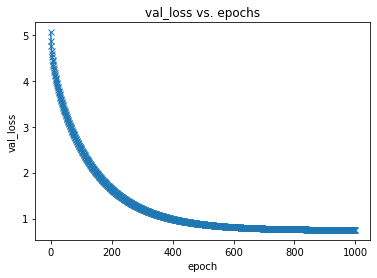

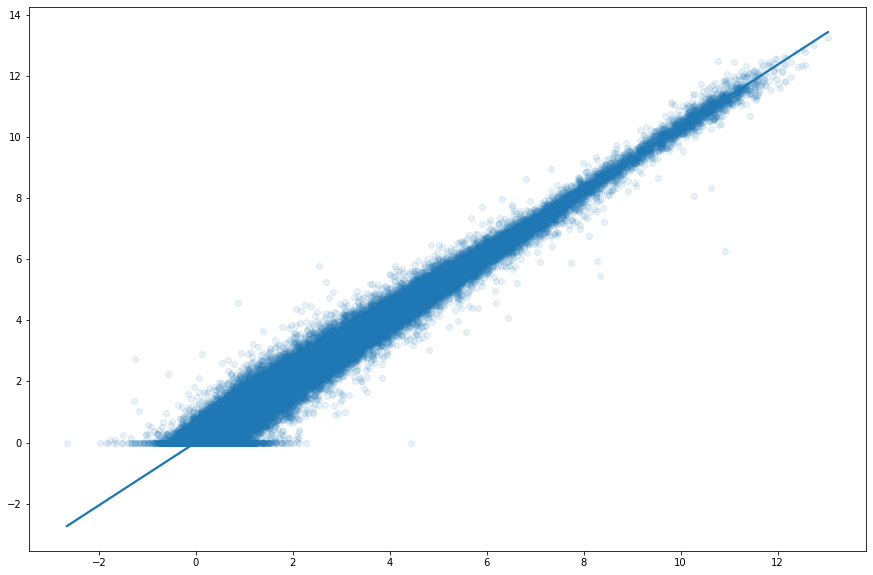

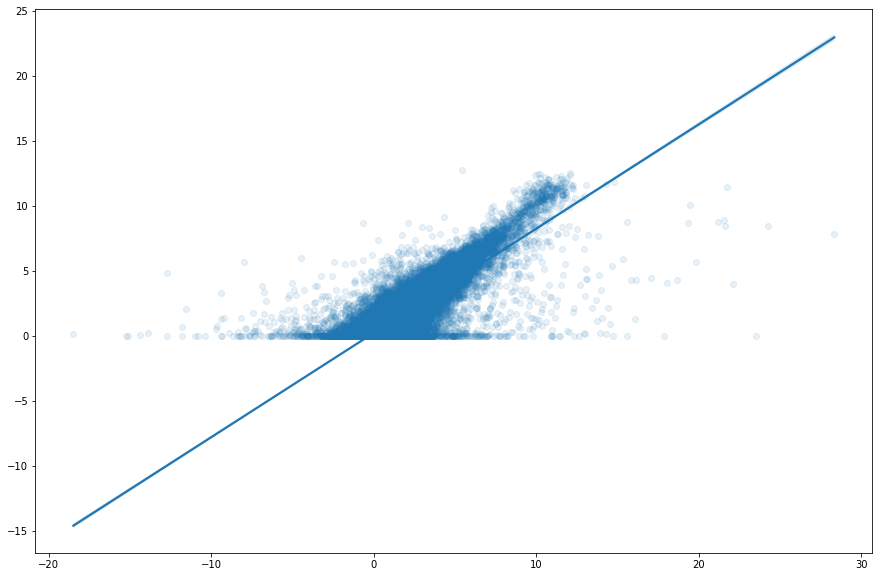

<Figure size 1080x720 with 0 Axes>

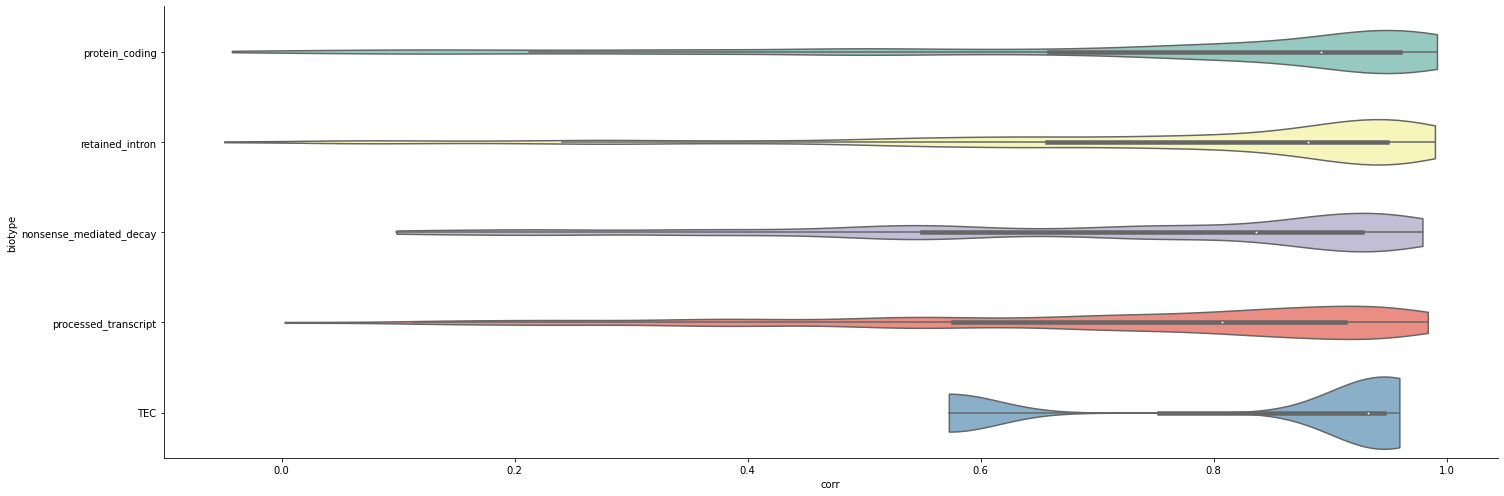

<Figure size 1080x720 with 0 Axes>

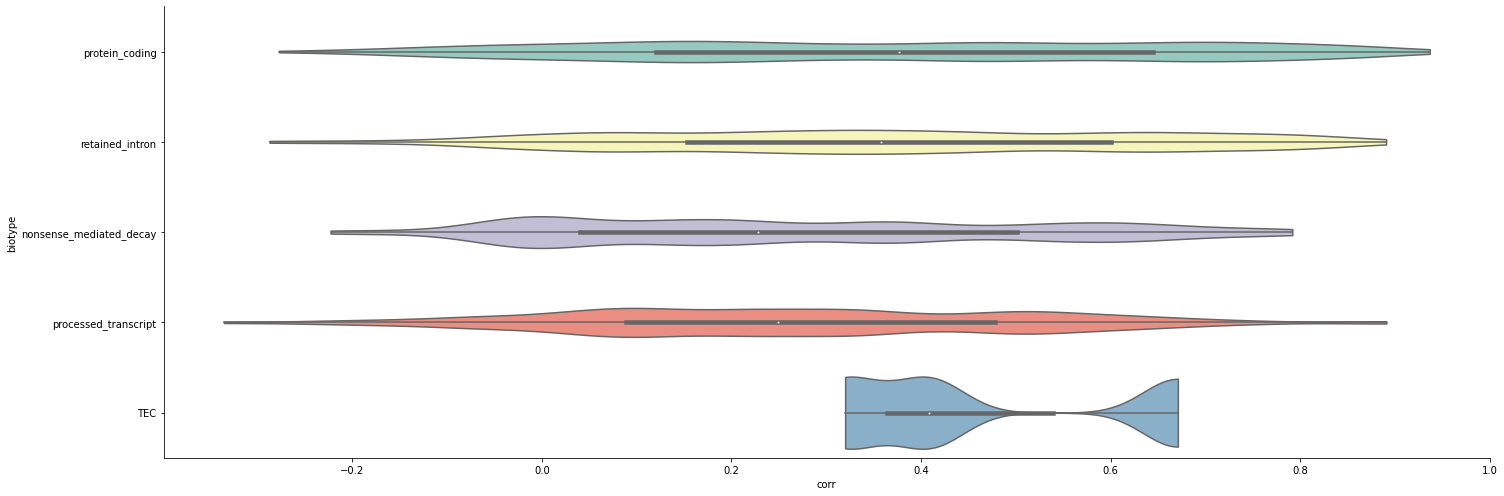

In [10]:
model_linear = DeepSF(n_inputs=TCGA_tpm_gn_RBPs.shape[1], n_outputs=TCGA_tpm_without_uniqueiso_log2p.shape[1])
history = fit(1000, learning_rate, model_linear, train_loader, val_loader, opt_func=torch.optim.SGD)

# Plot results
val_loss_vs_epoch(history)
solution = plot_pred_vs_real(scaledTrain_df, train_labels, scaled_train_gn, model_linear) # training
print('cor_train:', solution.cor_total)
print('cor_trans_train:', solution.cor_trans)

solution2 = plot_pred_vs_real(scaledValidation_df, valid_labels, scaled_valid_gn, model_linear) # validation
print('cor_val:', solution2.cor_total)
print('cor_trans_val:', solution2.cor_trans)

corr_vs_biotype(getBM, train_labels, solution.cor_trans)
corr_vs_biotype(getBM, train_labels, solution2.cor_trans)

In [ ]:
# Optimization with wandb   
model_linear = DeepSF(n_inputs=TCGA_tpm_gn_RBPs.shape[1], n_outputs=TCGA_tpm_without_uniqueiso_log2p.shape[1])
wandb_train(model_linear, train_loader, val_loader, config, name_project = "pytorch-demo")

# Model 2hidden layer with gene expression

Epoch [0], loss: 3.3423, val_loss: 3.4559
Epoch [1], loss: 3.3173, val_loss: 3.4216
Epoch [2], loss: 3.2714, val_loss: 3.3439
Epoch [3], loss: 3.1497, val_loss: 3.1270
Epoch [4], loss: 2.8070, val_loss: 2.5715
Epoch [5], loss: 2.1056, val_loss: 1.8002
Epoch [6], loss: 1.4958, val_loss: 1.4073
Epoch [7], loss: 1.1761, val_loss: 1.2596
Epoch [8], loss: 1.0122, val_loss: 1.2183
Epoch [9], loss: 0.9241, val_loss: 1.1886
Epoch [10], loss: 0.8688, val_loss: 1.1536
Epoch [11], loss: 0.8317, val_loss: 1.1377
Epoch [12], loss: 0.8026, val_loss: 1.1270
Epoch [13], loss: 0.7839, val_loss: 1.1037
Epoch [14], loss: 0.7659, val_loss: 1.0789
Epoch [15], loss: 0.7510, val_loss: 1.0795
Epoch [16], loss: 0.7403, val_loss: 1.0743
Epoch [17], loss: 0.7283, val_loss: 1.0502
Epoch [18], loss: 0.7193, val_loss: 1.0556
Epoch [19], loss: 0.7110, val_loss: 1.0336
Epoch [20], loss: 0.7035, val_loss: 1.0372
Epoch [21], loss: 0.6958, val_loss: 1.0177
Epoch [22], loss: 0.6896, val_loss: 1.0134
Epoch [23], loss: 0.6

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


cor_train: 0.7889445175406329
cor_trans_train: [0.9183979748175989, 0.9317166016038104, 0.8968245791444734, 0.955144145459186, nan, 0.7546905319348796, 0.9502455522810429, 0.9472085637618419, 0.872666982061554, 0.9262610149274203, 0.9144490724433965, 0.9660213368981634, 0.755251107860711, 0.19607653936006367, nan, 0.9348650855381615, 0.9172238282097946, 0.9340379843177207, 0.5718956044042199, 0.9010897399728297, -0.29848019051557034, 0.1727390654547075, 0.904849304901497, 0.870429667663488, 0.8854334220200607, nan, 0.912421519636086, 0.15825746548721173, 0.7939159892187032, nan, nan, 0.7971600485740443, 0.4796501422810471, 0.9646479585414867, 0.7151661553467548, 0.7398464177756073, 0.8027630108899703, 0.7291943748017146, 0.8474098945261895, 0.8927150533616429, 0.8657309056031023, 0.9221764200365453, nan, -0.023793609556086368, 0.8909100082899664, 0.8450494716532606, 0.8663698624749091, 0.0664326686271017, nan, 0.9113788471304127, 0.6777284487772219, 0.06586237204003768, 0.9528802208342

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


cor_val: 0.7664416372748588
cor_trans_val: [0.4704910063198832, 0.7622195985832347, 0.4620181957080353, 0.6859087436627543, nan, 0.43284950343773865, 0.5248420029168691, 0.7266852445168072, 0.6950829918744357, 0.7678033196749774, 0.7896714332535271, 0.7008681158413776, 0.5289811792485589, 0.13599007399878976, nan, 0.4939440238905478, 0.6802986371370064, 0.6313702340440308, 0.343416216497786, 0.6650809083964163, -0.27203454462452403, 0.16303302549979676, 0.7641919577748454, 0.6202236266407387, 0.4494548232516146, nan, 0.6359191610528508, 0.25478296112899923, 0.6083339120772275, nan, nan, 0.8270623532133996, 0.5668311300218338, 0.7918674907979719, 0.5497619398769846, 0.3407829764855882, 0.56103201611223, 0.35896650685575493, 0.6614169512881485, 0.5359747204666989, 0.572029807846338, 0.5488020001388985, nan, nan, 0.4651434127369955, 0.7966502165868045, 0.4807450569256636, nan, nan, 0.6844294742690464, 0.6140267701771946, -0.03878143436235144, 0.748392249461768, 0.7450713447517149, 0.70003

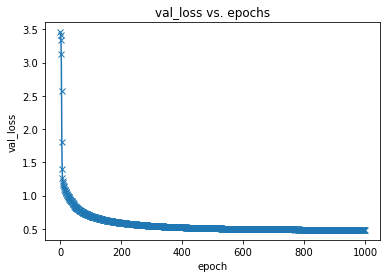

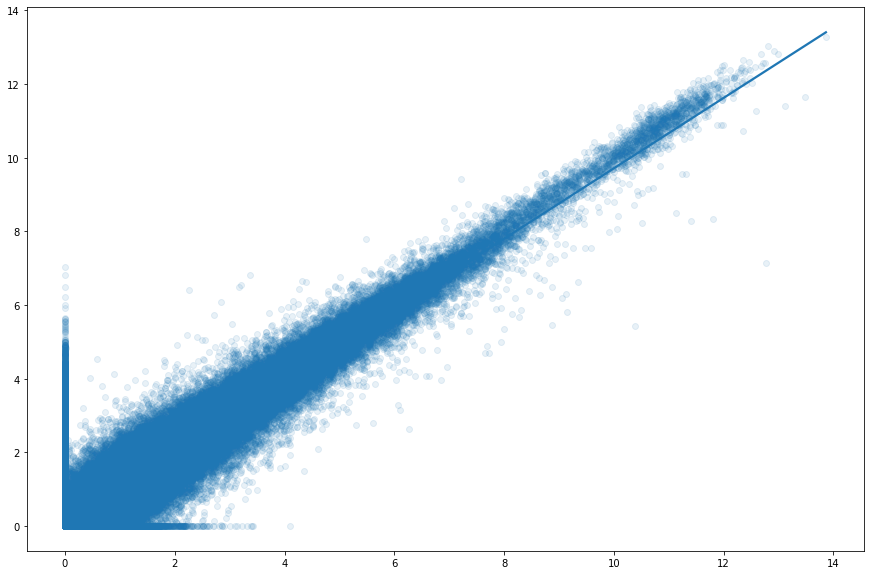

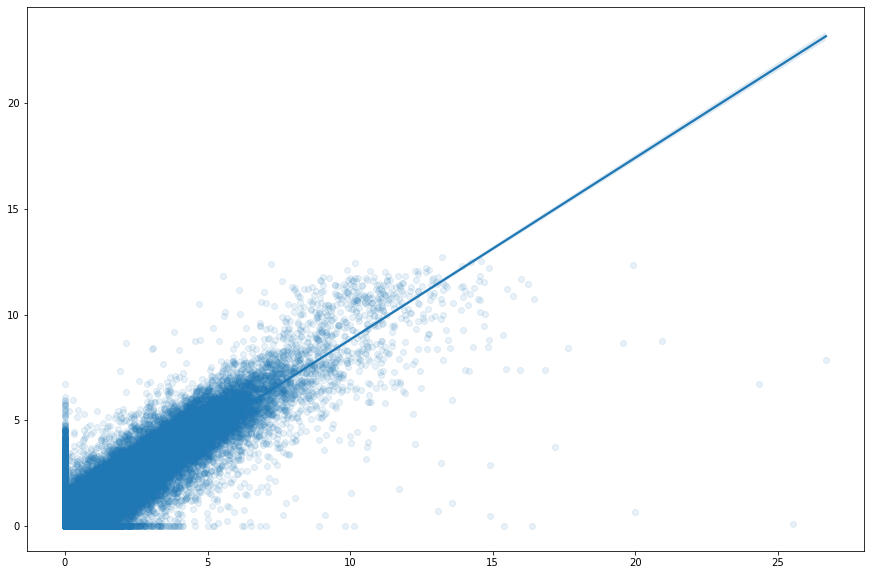

<Figure size 1080x720 with 0 Axes>

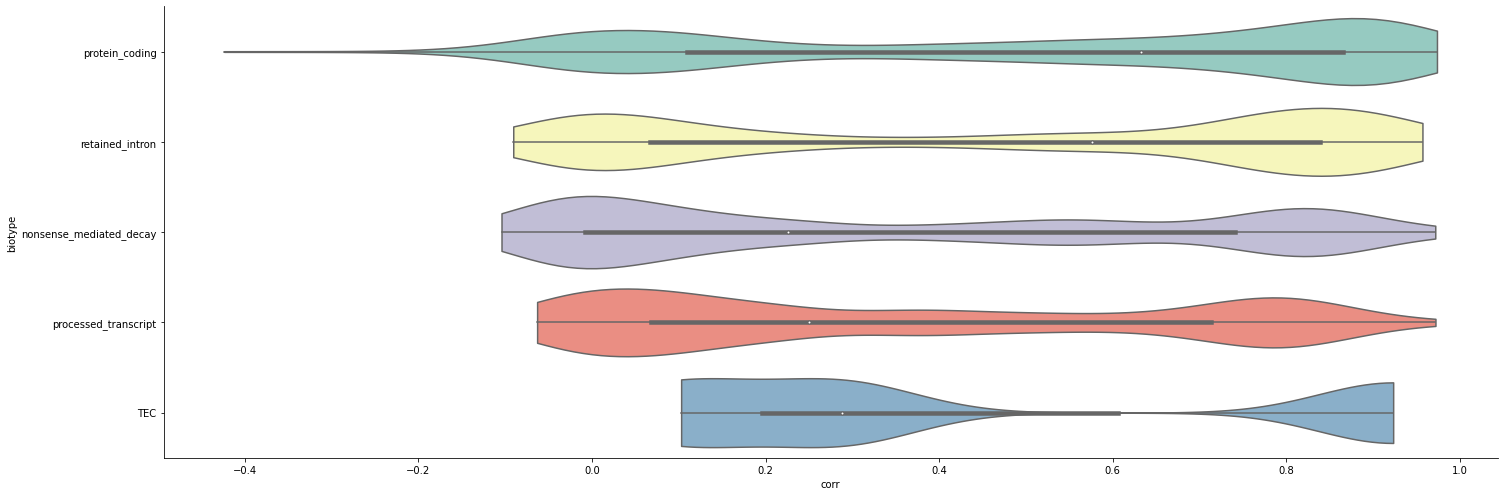

<Figure size 1080x720 with 0 Axes>

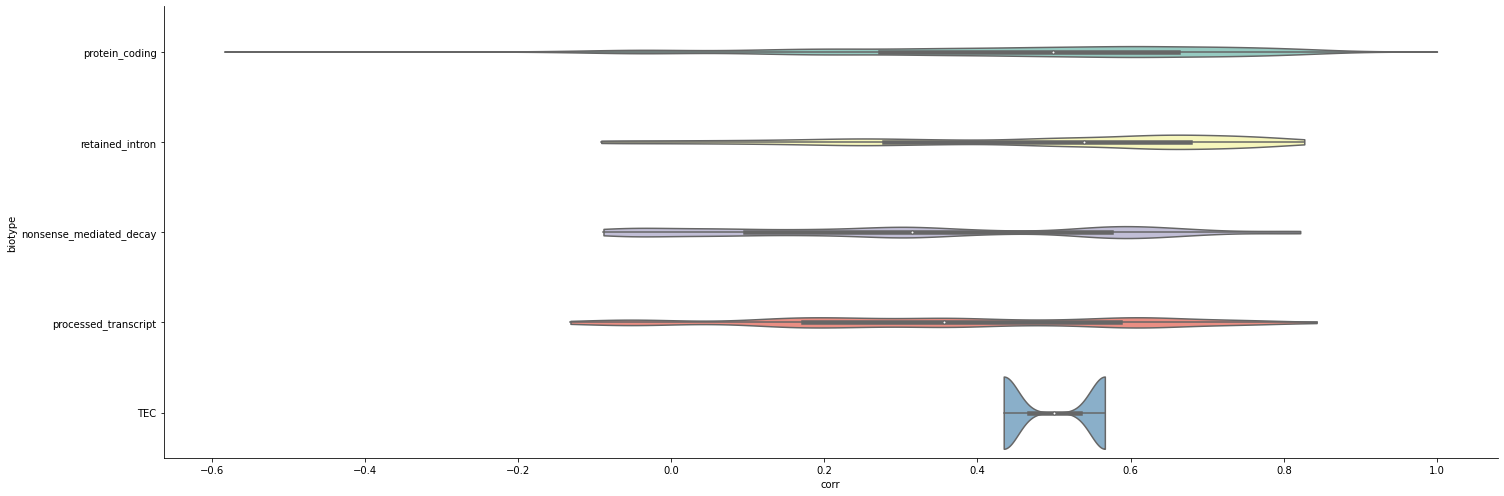

In [7]:
model_2hidden = DeepSF_2hidden(n_inputs=TCGA_tpm_gn_RBPs.shape[1], n_outputs=TCGA_tpm_without_uniqueiso_log2p.shape[1])
history = fit(1000, learning_rate, model_2hidden, train_loader, val_loader, opt_func=torch.optim.SGD)

# Plot the results
val_loss_vs_epoch(history)

solution_2hidden = plot_pred_vs_real(scaledTrain_df, train_labels, scaled_train_gn, model_2hidden) # training
print('cor_train:', solution_2hidden.cor_total)
print('cor_trans_train:', solution_2hidden.cor_trans)

solution_val_2hidden = plot_pred_vs_real(scaledValidation_df, valid_labels, scaled_valid_gn, model_2hidden) # validation
print('cor_val:', solution_val_2hidden.cor_total)
print('cor_trans_val:', solution_val_2hidden.cor_trans)

corr_vs_biotype(getBM, train_labels, solution_2hidden.cor_trans)
corr_vs_biotype(getBM, train_labels, solution_val_2hidden.cor_trans)

In [ ]:
# Boxplot comparar modelos:
corr_values = np.concatenate((solution2.cor_trans, solution_val_2hidden.cor_trans), axis=0)
model_name = np.concatenate((['Model_Linear' for i in solution2.cor_trans], ['Model_2hidden' for i in solution_val_2hidden.cor_trans]), axis=0)

data =  {'model':model_name,
           'corr': corr_values}
         
data_df = pd.DataFrame(data)
ax = sns.boxplot(x="model", y="corr",
                 data=data_df, palette="Set3")

In [ ]:
# Optimization with wandb   
model_2hidden = DeepSF(n_inputs=TCGA_tpm_gn_RBPs.shape[1], n_outputs=TCGA_tpm_without_uniqueiso_log2p.shape[1])
wandb_train(model_2hidden, train_loader, val_loader, config, name_project = "pytorch-demo")